# DeMetRA - review figures

In [3]:
import pandas as pd
# import os
# os.getcwd()

## Is-processed dataset

In [24]:
results_directory = 'src_shiny_app/assets/'

d_raw, base_ss, base_va = pd.read_excel(f'{results_directory}MPS_review_systematic_2025-02-14.xlsx', sheet_name=[0, 1, 2]).values()
d = d_raw.loc[d_raw.Include == 'Yes'].drop('Include', axis=1)

/Users/Serena/Desktop/DEMETRA/DeMetRA-review/demetra_venv/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/Users/Serena/Desktop/DEMETRA/DeMetRA-review/demetra_venv/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [7]:
print(d.shape, base_ss.shape, base_va.shape)

(760, 39) (20, 12) (150, 32)


In [99]:
tissue_colors = {
    'Peripheral blood': 'crimson',
    'Whole blood': 'gold',
    'Cord blood': 'brown',
    'Placenta': 'pink',
    'Blood-clots': 'blueviolet',
    'Dried bloodspot': 'indianred',
    'Saliva': 'lightblue',
    'Buccal cells': 'steelblue',
    'Nasal epithelial cells': 'teal',
    'Tumour cells': 'darkgreen',
    'Leukocytes': 'yellow',
    'Leukocytes': 'yellow',
    'Bone marrow granulocytes': 'magenta',
    'Not reported': 'darkgrey'
}

NameError: name 'tissue_colors' is not defined

In [25]:
# cleaning 
def checklvl(var):
    allobs = pd.concat([d[var], base_ss[var], base_va[var]])
    print(allobs.value_counts(dropna=False))

for v in  ['Tissue', 'Array','Ancestry','Developmental_period']:
    checklvl(v)
    print('\n')
    try: 
        checklvl(f'Multiple_{v.lower()}')
        print('\n')
    except:
        pass
   

Tissue
Peripheral blood          497
Whole blood               151
Saliva                    120
Cord blood                 48
Dried bloodspot            26
Blood-clots                26
Buccal cells               20
Placenta                   15
Nasal epithelial cells      7
Tumour cells                4
Multiple                    4
Leukocytes                  3
Tumour                      3
Blood                       2
Not reported                1
Cervical cells              1
White blood cells           1
Bucal                       1
Name: count, dtype: int64


Multiple_tissue
NaN                             926
Whole blood, HPCs                 2
Cord blood, dried blood spot      1
Cord blood, whole blood           1
Name: count, dtype: int64


Array
Multiple    440
EPICv1      285
450K        191
WGBS         14
Name: count, dtype: int64


Multiple_array
NaN                                    490
450K, EPICv1                           426
450K, GMEL (~3000 CpGs from EPICv1)   

In [9]:
f2_vars = ['Identifier', 'What_is_available', 'Identifier_base', 'Multiple_identifier_base', 
           'Category', 'Phenotype', 
           'Tissue', 'Multiple_tissue', 
           'Array', 'Multiple_array',
           'Ancestry', 'Multiple_ancestry', 
           'Developmental_period', 
           'Covariates',
           'Title', 'Year', 'Sample_size_total',
           'Sample_overlap_target_base']

d_targ = d.loc[d.What_is_available != 'Only phenotype', f2_vars]
d_targ.shape

(283, 18)

In [10]:
d_targ.groupby(d_targ.What_is_available).Identifier_base.value_counts(dropna=False)

What_is_available        Identifier_base                                                              
EWAS summary statistics  Reese (2019) - Epigenome-wide meta-analysis of                                    14
                         Joubert (2017) - DNA Methylation in Newborns and                                  11
                         Sikdar (2019) - Comparison of smoking-related DNA                                 10
                         Multiple                                                                           7
                         Kupers (2019) - Meta-analysis of epigenome-wide                                    6
                         Wahl (2019) - Epigenome-wide association study of                                  6
                         Chen (2017) - An epigenome-wide association study                                  4
                         Everson (2015) - DNA methylation loci associated with                              4
                 

In [11]:
# Merge info about target with info about base (for summary statistics)
bt1 = d_targ.loc[d_targ.What_is_available=='EWAS summary statistics', ].merge(base_ss,
                                                                          left_on='Identifier_base', 
                                                                          right_on='Identifier', 
                                                                          how='left', suffixes=['_targ','_base'])
# Reorder columns for more easy exporation 
bt1 = bt1[sorted(bt1.columns)]

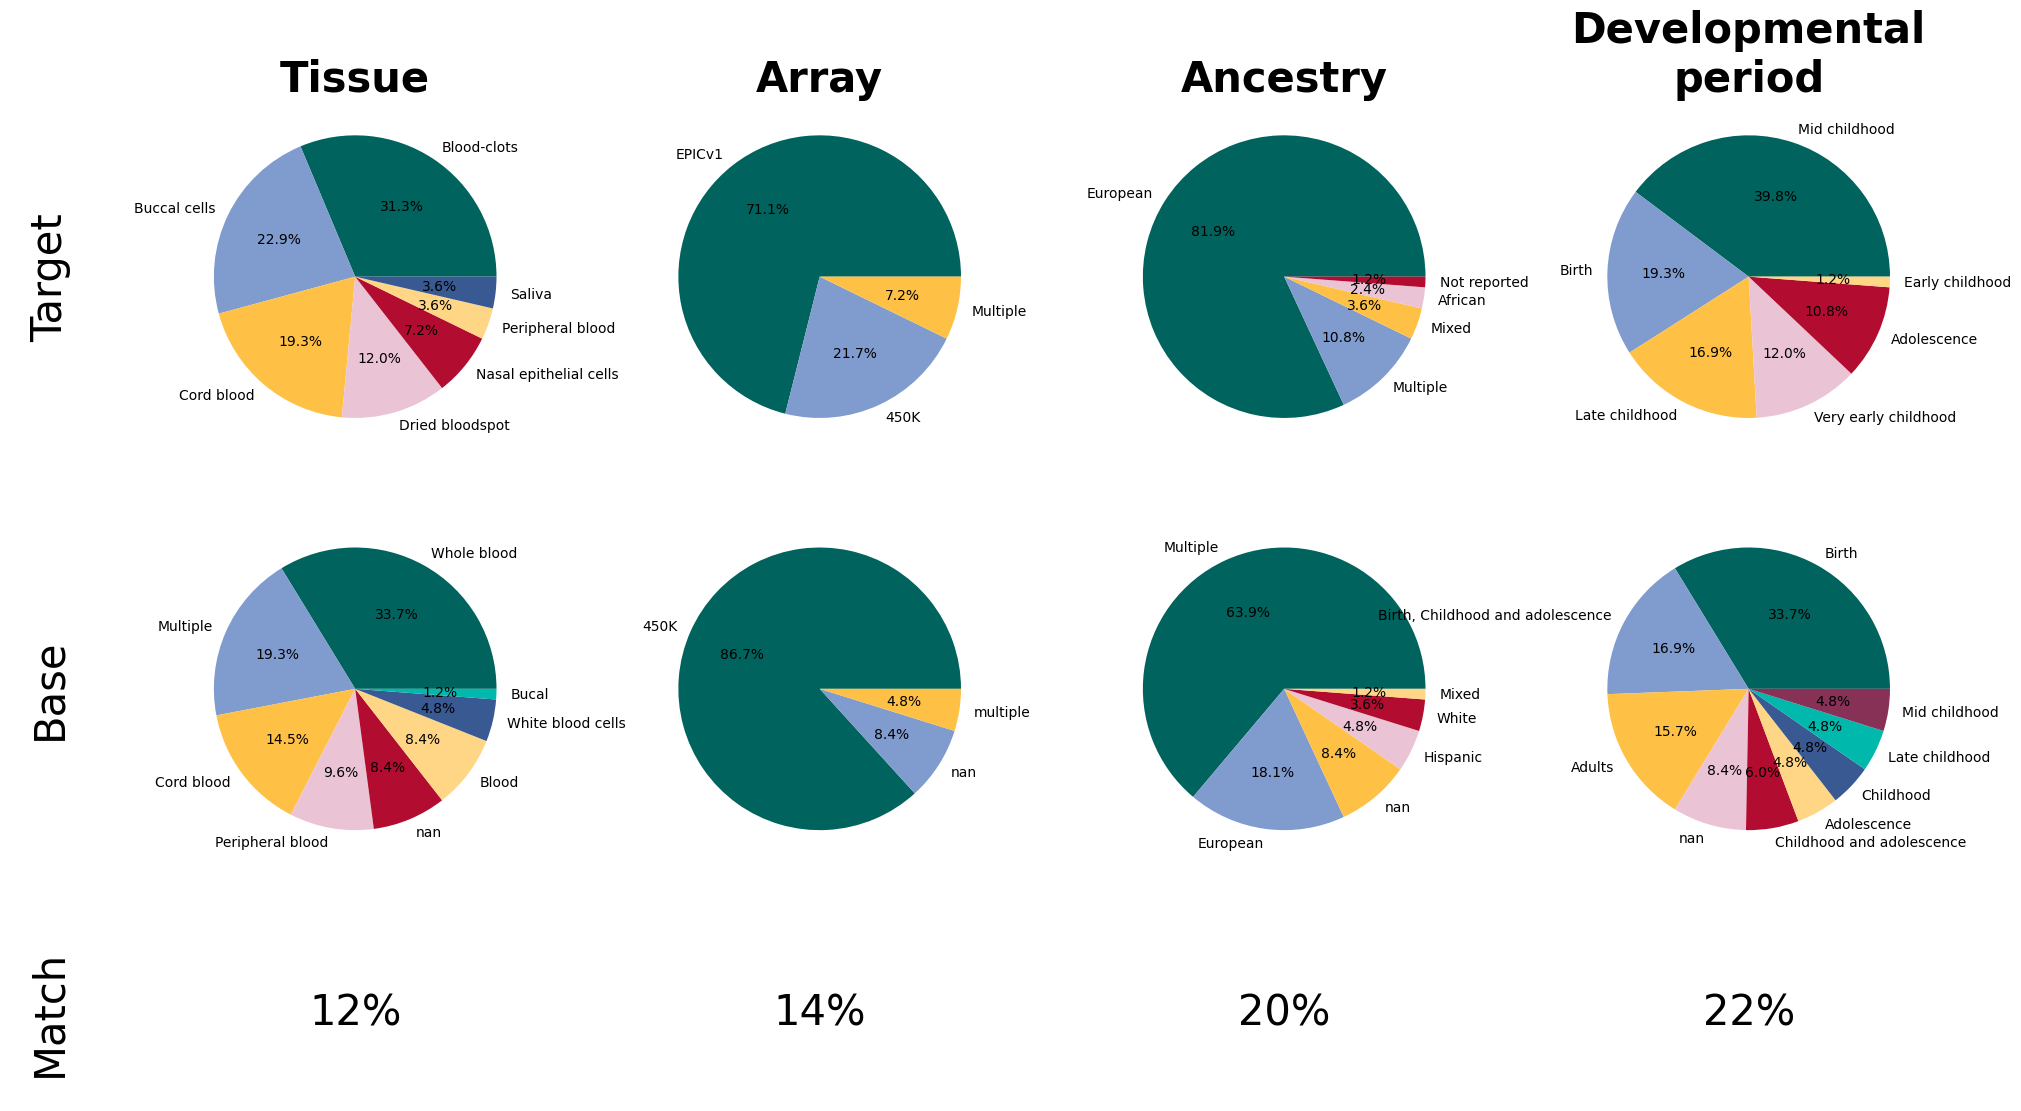

In [96]:
def pie_count(ax, var, df=bt1):

    count = df.value_counts(var, dropna=False)
    labels = count.index
    sizes = count
    
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=demetra_pallete.values())


def base_target_overlap(var, df=bt1):
    ovlp = df[f'{var}_base'] == df[f'{var}_targ']
    return(f'{round((sum(ovlp) / len(ovlp))*100)}%')


def compare_base_target(var_list, df=bt1):

    fs = dict(big=30, small=15)

    row_targ = list()
    row_base = list()
    row_ovlp = list()

    for i in range(len(var_list)+1):  
        row_targ.append(f'A{i}')
        row_base.append(f'B{i}')
        row_ovlp.append(f'C{i}')
    
    fig, axs = plt.subplot_mosaic([row_targ, row_base, row_ovlp], figsize=(25, 13), 
                                  height_ratios=[1,1,.5], width_ratios=[.2]+[1]*len(var_list))
    

    label_txt = dict(x=.5, y=.5, ha='center', va='center', fontsize=fs['big'], rotation=90)
    
    axs['A0'].text(s='Target', transform=axs['A0'].transAxes, **label_txt)
    axs['B0'].text(s='Base', transform=axs['B0'].transAxes, **label_txt)
    axs['C0'].text(s='Match', transform=axs['C0'].transAxes, **label_txt)

    [axs[i].axis('off') for i in ['A0', 'B0', 'C0']]

    for i, var in enumerate(var_list):
        
        pie_count(axs[f'A{i+1}'], f'{var}_targ')
        pie_count(axs[f'B{i+1}'], f'{var}_base')

        axs[f'C{i+1}'].text(x=.5, y=.5, s=base_target_overlap(var), fontsize=fs['big'], ha='center', va='center', 
                           transform=axs[f'C{i+1}'].transAxes)
        axs[f'C{i+1}'].axis('off')

        axs[f'A{i+1}'].set_title('\n'.join(var.split('_')), fontsize=fs['big'], fontweight='bold') 


compare_base_target(var_list = ['Tissue', 'Array','Ancestry','Developmental_period'])

In [17]:
from pySankey import sankey

colorDict = {
    'Multiple':'#f71b1b',
    'EPICv1':'#1b7ef7',
    '450K':'#f3f71b',
    'WGBS':'#12e23f',
    'multiple':'#f78c1b'
}
bt1 = bt1.dropna()
sankey.sankey(
    bt1['Array_base'], bt1['Array_targ'], aspect=20, colorDict=colorDict,
    fontsize=12
)

UnboundLocalError: local variable 'topEdge' referenced before assignment

<Figure size 640x480 with 0 Axes>

In [13]:
# Specify colors to use for categorical variables
# qprint(["Category"])
category_color_map = {'Syndrome': 'royalblue',
                      'Disease': 'firebrick',
                      'Protein': 'darkviolet',
                      'Lifestyle': 'gold',
                      'Psychiatric': 'teal',
                      'Environmental exposure': 'limegreen',
                      'Birth outcome': 'lightblue',
                      'Tumour': 'pink',
                      'Aging phenotype': 'darkgrey'}

tissue_color_map = {'Peripheral blood': 'crimson',
                    'Whole blood': 'gold',
                    'Cord blood': 'brown',
                    'Placenta': 'pink',
                    'Blood-clots': 'blueviolet',
                    'Dried bloodspot': 'indianred',
                    'Saliva': 'lightblue',
                    'Buccal cells': 'steelblue',
                    'Nasal epithelial cells': 'teal',
                    'Tumour cells': 'darkgreen',
                    'Leukocytes': 'yellow',
                    'Leukocytes': 'yellow',
                    'Bone marrow granulocytes': 'magenta',
                    'Not reported': 'darkgrey'}

array_color_map = {'EPICv2': 'darkblue',
                   'EPICv1': 'mediumblue',
                   '450K, EPICv1': 'seagreen',
                   '450k': 'orange',
                   '450K, GMEL (~3000 CpGs from EPICv1)':'orange',
                   'WGBS': 'magenta'}

color_maps = {'Category': category_color_map, 
              'Tissue': tissue_color_map,
              'Array': array_color_map}

demetra_pallete = {
    'caribbean-current': '#00635dff',
    'vista-blue': '#809bceff',
    'xanthous': '#ffc145ff',
    'fairy-tale': '#eac4d5ff',
    'red-ncs': '#b20d30ff',
    'jasmine': '#ffd685ff',
    'yinmn-blue': '#395993ff',
    'light-sea-green': '#00b8abff',
    'quinacridone-magenta': '#873157ff',
    'lavender-blush': '#feecf0ff'}

In [4]:
d.columns

Index(['Identifier', 'Type', 'Author', 'Year', 'Title', 'Journal', 'DOI',
       'pdf', 'Sample_size_total', 'Sample_size_control', 'Sample_size_case',
       'Sample_type', 'Category', 'Phenotype', 'What_is_available',
       'Identifier_base', 'Multiple_identifier_base', 'Tissue',
       'Multiple_tissue', 'Array', 'Multiple_array', 'Ancestry',
       'Multiple_ancestry', 'Developmental_period', 'Covariates',
       'Sample_overlap_target_base', 'Including_CpGs_1', 'Including_CpGs_2',
       'Including_CpGs_3', 'Including_CpGs_4', 'Including_CpGs_5',
       'Number of CpGs', 'Determining_weights_1', 'Train_test',
       'Independent_validation', 'Comparison', 'Missing_value_note',
       'Reflect_phenotype', 'Link'],
      dtype='object')

In [9]:
def qprint(cols, d = d):
    for c in cols: 
        print(d.value_counts(c, dropna=False), '\n')
    
# qprint(['Type', 'Year', #'Journal', 
#         'Sample_type',
#         'Developmental period', 
#         'Category', # 'Phenotype', 'Tissue', 'Multiple_tissue', 
#         'Array',]) #'Multiple_array'])

qprint(d.columns)

Identifier
178    278
110    104
9       44
140     25
98      19
      ... 
181      1
187      1
188      1
189      1
191      1
Name: count, Length: 89, dtype: int64 

Type
Journal Article    703
Book                45
Generic             12
Name: count, dtype: int64 

Author
S. Waterfield; P. D. Yousefi; M. Suderman                                                                                                                                                                                                                                278
K. McKinnon; E. L. S. Conole; K. Vaher; R. F. Hillary; D. A. Gadd; J. Binkowska; G. Sullivan; A. J. Stevenson; A. Corrigan; L. Murphy; H. C. Whalley; H. Richardson; R. E. Marioni; S. R. Cox; J. P. Boardman                                                            104
E. Aref-Eshghi; J. Kerkhof; V. P. Pedro                                                                                                                                              

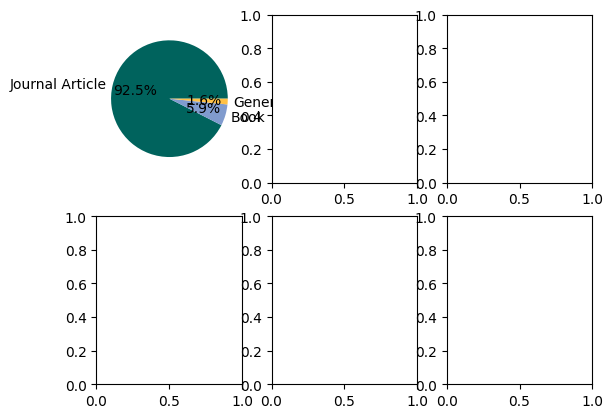

In [17]:


def pie_count(ax, var):

    count = d.value_counts(var, dropna=False)
    labels = count.index
    sizes = count
    
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=demetra_pallete.values())

fig, axs = plt.subplot_mosaic('ABC;DEF') 

pie_count(axs['A'], 'Type')

## Bibliography dataset

In [ ]:
# Preprocessing functions

# Date formatting
from dateutil.parser import parse

def is_date(string, fuzzy=False):
    """
    Return whether the string can be interpreted as a date.

    :param string: str, string to check for date
    :param fuzzy: bool, ignore unknown tokens in string if True
    """
    try: 
        parse(string, fuzzy=fuzzy)
        return True

    except ValueError:
        return False


# Extract information
def extract_info(prefixes, line, index):
    
    # Date is not always correctly labelled
    if is_date(line):
        bib.loc[index, "Date"] = line[:-1]
        return True
    
    for prefix in prefixes:
        if line.startswith(prefix):
            bib.loc[index, prefix[:-2]] = line[len(prefix):-1]
            break
            

In [ ]:
# Initialise
n = 1 
bib = pd.DataFrame()           

# Extract info
with open("Step2_AfterAbstractScreening_2024-07-13.txt", 'r') as file:
    for line in file:
        if line.startswith("Reference Type"):
            continue
        if line.startswith("Record Number"):
            # record counter updated for every new record
            n = int(''.join(i for i in line if i.isdigit())) 
            bib.loc[n-1, 'Identifier'] = int(n)

        extract_info([s + ": " for s in ["Author", "Year", "Title", "Journal", "Abstract", "Date",
                                         "Short Title", "DOI", "URL"]],
                                         # "Volume", "Issue", "Pages", "ISSN", "Accession Number", "Label", "Type of Article",
                                         # "Notes", "Author Address", "Name of Database", "Language"
                                         line, n-1)
        
        # TODO: extract keywords

# bib.set_index('Identifier');

# Correct dates 
bib["Date2"] = pd.Series([' '.join([d, y]) if y not in d else d if not d=="nan" else y for d, y in zip(bib.Date.map(str), bib.Year.map(str))])
bib["Date2"] = bib.Date2.apply(lambda date: parse(date).strftime("%Y-%m-%d") if not "nan" in date else parse("01 01"+date[3:]).strftime("%Y-%m-%d")) # 

# Check
# pd.options.display.max_columns = 200
# bib[["Date", "Year", "Date2"]]

# NOTES: some dates are not correct (years do not match) 
#        if only year is available set date to 01/01
#        if only month is available set day to 14th 


## Merge and clean information

In [ ]:
# bib.shape
data = pd.merge(d, bib[["Identifier", "Date2", "Short Title", "Abstract", "URL"]], how="left", on="Identifier")
# NOTE: DOI info could be correct in bib in some cases...?


In [ ]:
# Some other tmp clean-ups: 
data.loc[data.Phenotype.str.contains("BAFopathy syndrome: Coffin-Siris"), "Category"] = "Syndrome"
data.loc[data.Phenotype.str.contains("Intellectual developmental disorder, X-linked"), "Category"] = "Psychiatric"

# Sample size to numeric
data["Sample size"] = pd.to_numeric(data["Sample size"], errors='coerce') # removed the "- check"
# Dates to dates
data["Date"] = pd.to_datetime(data["Date2"], errors='coerce')

# Combine array info
data["Array"] = [i if i != "Multiple" else j for i,j in zip(data['Array'], data['Multiple_array'])]

In [ ]:
print(list(data.columns))

In [ ]:
# data["Coined"].value_counts()

# Figures 

In [ ]:
# Specify colors to use for categorical variables
# qprint(["Category"])
category_color_map = {'Syndrome': 'royalblue',
                      'Disease': 'firebrick',
                      'Protein': 'darkviolet',
                      'Lifestyle': 'gold',
                      'Psychiatric': 'teal',
                      'Environmental exposure': 'limegreen',
                      'Birth outcome': 'lightblue',
                      'Tumour': 'pink',
                      'Aging phenotype': 'darkgrey'}

tissue_color_map = {'Peripheral blood': 'crimson',
                    'Whole blood': 'gold',
                    'Cord blood': 'brown',
                    'Placenta': 'pink',
                    'Blood-clots': 'blueviolet',
                    'Dried bloodspot': 'indianred',
                    'Saliva': 'lightblue',
                    'Buccal cells': 'steelblue',
                    'Nasal epithelial cells': 'teal',
                    'Tumour cells': 'darkgreen',
                    'Leukocytes': 'yellow',
                    'Leukocytes': 'yellow',
                    'Bone marrow granulocytes': 'magenta',
                    'Not reported': 'darkgrey'}

array_color_map = {'EPICv2': 'darkblue',
                   'EPICv1': 'mediumblue',
                   '450K, EPICv1': 'seagreen',
                   '450k': 'orange',
                   '450K, GMEL (~3000 CpGs from EPICv1)':'orange',
                   'WGBS': 'magenta'}

color_maps = {'Category': category_color_map, 
              'Tissue': tissue_color_map,
              'Array': array_color_map}


### Sample over the years

In [ ]:
def sample_size_over_time(color_by = "Category", log_sample_size = True, model_type="ols", scope = "overall"):
    # Color set-up
    if color_by in color_maps.keys():
        color_map = color_maps[color_by]
    else: 
        color_map = "Virdis"

    line_color = "grey" if scope == "overall" else None
    model_options = dict(log_y=log_sample_size) if model_type == "ols" else dict(frac=1)
        
        
    # Plot
    fig = px.scatter(data, x="Date", y="Sample size", log_y=log_sample_size, 
                     color=color_by, color_discrete_map = color_map,
                     hover_name=data.Title.apply( lambda t: "<br>".join(textwrap.wrap(t, width=80))), hover_data="Phenotype",
                     trendline=model_type, trendline_scope=scope, trendline_color_override=line_color, 
                     trendline_options=model_options,
                     title="Sample size over time")
    # Make it pretty 
    fig.update_traces(marker=dict(size=10, opacity = .5))
    axes_style = dict(mirror=True, ticks='outside', showline=True, linecolor='black', gridcolor='lightgrey')
    ylabel_note = " (log scale)" if log_sample_size else ""
    fig.update_yaxes(title_text='<b>Sample size</b>'+ylabel_note, **axes_style)
    fig.update_xaxes(title_text='Publication date', **axes_style)
    fig.update_layout(plot_bgcolor='whitesmoke', width=1300, height=400, margin=dict(l=10, r=10, t=25, b=10))
    
    fig.show()

sample_size_over_time()
sample_size_over_time(log_sample_size = False)
sample_size_over_time(model_type="lowess", log_sample_size = False)
sample_size_over_time(model_type="ols", log_sample_size = False, scope="trace")

In [ ]:
def category_over_years(color_by="Category", percent = True, width=1300, height=400): 
    # Color set-up
    if color_by in color_maps.keys():
        color_map = color_maps[color_by]
    else: 
        color_map = "Virdis"

    norm = "percent" if percent else None
    
    fig = px.histogram(data, x="Year", color=color_by, barnorm=norm,
                   color_discrete_map = color_map,
                   title=f"{color_by} over time", width=width, height=height)
    fig.show()

category_over_years()
category_over_years("Tissue", height=450)
category_over_years("Array")

category_over_years(percent=False)
category_over_years("Tissue", height=450, percent=False)
category_over_years("Array", percent=False)

In [ ]:
fig = px.histogram(data, x="Category", color="Tissue",
                   color_discrete_map = tissue_color_map,
                   category_orders = {"Category": list(data["Category"].value_counts().index)},
                   title="Category counts by tissue", width=1400, height=450)
fig

In [ ]:
counts = data[["Category","Phenotype"]].value_counts().reset_index()
fig1 = px.sunburst(counts, 
                  path=['Category','Phenotype'], values='count',
                  color = "Category", color_discrete_map = category_color_map, 
                  width=1200, height=750,
                  title="Number of MPSs per phenotype")

fig2 = px.sunburst(data, 
                  path=['Category','Phenotype'], values='Sample size',
                  color = "Category", color_discrete_map = category_color_map, 
                  width=1200, height=750,
                  title="Combined sample size per phenotype")
fig1.show()
fig2.show()

In [ ]:
def n_scores_by_pub(color_by="Category"):
    # Color set-up
    if color_by in color_maps.keys():
        color_map = color_maps[color_by]
    else: 
        color_map = "Virdis"
    
    fig = px.histogram(data,
                       x="Title", color=color_by, color_discrete_map = color_map, 
                       nbins=186, # Number of papers
                       # hover_name=data.Title.apply( lambda t: "<br>".join(textwrap.wrap(t, width=80))), 
                       # hover_data=["Sample size","Journal"],
                       # category_orders = {"Category": list(data["Category"].value_counts().index)},
                       title="Number of MPSs by publication", width=1400, height=500).update_xaxes(categoryorder="total ascending")
    # Make it pretty 
    axes_style = dict(mirror=True, showline=True, linecolor='black')
    fig.update_yaxes(title_text='<b>Number of MPSs</b>', gridcolor='lightgrey', ticks='outside', **axes_style, 
                     tickmode = 'array',
                     tickvals = [1, 5, 10, 20, 30, 40, 50, 70, 100])
    fig.update_xaxes(title_text='<b>Publication</b>', **axes_style, 
                     showticklabels=False)
    fig.update_layout(plot_bgcolor='whitesmoke', margin=dict(l=10, r=10, t=25, b=10))
    
    fig.show()


n_scores_by_pub()
n_scores_by_pub("Tissue")
n_scores_by_pub("Array")

In [ ]:
# Create fictional age data
age_encoding = {
    "Birth": [0, 0, 0],
    "Very early childhood": [1, 0, 2],
    "Early childhood": [3, 2, 4],
    "Mid childhood": [5, 4, 7],
    "Late childhood": [9, 8, 11],
    "Childhood": [5, 1, 11],
    "Childhood and adolescence": [13, 10, 16],
    "Adolescence": [14, 12, 18],
    "Not reported": [20, 20, 20]
}

data[["Age_median","Age_min","Age_max"]] = [age_encoding[l] for l in data["Developmental period"]]

# Plot
fig = px.scatter(data, x="Age_median", y="Tissue", size=data["Sample size"].fillna(0), size_max = 70,
                 error_x=data["Age_max"] - data["Age_median"], error_x_minus=data["Age_median"] - data["Age_min"],
                 hover_name=data.Title.apply( lambda t: "<br>".join(textwrap.wrap(t, width=80))),
                 color="Category", color_discrete_map = category_color_map)

# Make it pretty 
fig.update_traces(marker=dict(opacity = .5))
axes_style = dict(mirror=True, ticks='outside', showline=True, linecolor='black', gridcolor='lightgrey')
fig.update_yaxes(title_text='<b>Tissue</b>', **axes_style)
fig.update_xaxes(title_text='<b>Age of the sample</b> (years) {median, range}', **axes_style, 
                 tickmode = 'array',
                 tickvals = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
                 ticktext = ["Birth", 2, 4, 6, 8, 10, 12, 14, 16, 18, "Not reported"])
fig.update_layout(plot_bgcolor='whitesmoke', width=1400, height=600, margin=dict(l=10, r=10, t=25, b=10))

fig

In [ ]:
# Plot
fig = px.histogram(data, x="Number of CpGs", color="Category", # log_y=True, # barnorm="percent",
                   # animation_frame="Number of CpGs bins", # animation_group="Category",
                   color_discrete_map = category_color_map, nbins=200,
                   category_orders = {"Category": list(data["Category"].value_counts().index)},
                   title="Number of CpGs by category", width=1400, height=700)

# Make it pretty 
axes_style = dict(mirror=True, ticks='outside', showline=True, linecolor='black', gridcolor='lightgrey')
fig.update_yaxes(title_text='<b>Count</b>', **axes_style)
fig.update_xaxes(title_text='<b>Number of CpGs</b>', **axes_style)
                 # tickmode = 'array',
                 # tickvals = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000],
                 # ticktext = ["1", "1k", "2k", "3k", "4k", "5k", "6k", "7k", "8k", "9k", ">10k"])

# Add range slider
fig.update_layout(
    plot_bgcolor='whitesmoke',
    xaxis=dict(
        # autorange=False,
        # range = [0, 1000], 
        rangeslider=dict(visible=True, 
                         autorange=False,
                         range=[0,1000]),
        type="linear"
    )
)

In [ ]:
# Clean up: TMP
data["Number of CpGs"] = pd.to_numeric(data["Number of CpGs"], errors='coerce')
data["Number of CpGs crop"] = [10_000 if i > 10_000 else i for i in data["Number of CpGs"]]
data["Number of CpGs bins"] = pd.cut(data["Number of CpGs"],
                                     bins=[0, 1_000, 5_000, 10_000, 160_000], include_lowest=True,
                                     labels=['< 1k', '1 to 5k', '5 to 10k', "> 10k"])

# Plot
fig = px.histogram(data, x="Number of CpGs", color="Category", # log_y=True, # barnorm="percent",
                   animation_frame="Number of CpGs bins", # animation_group="Category",
                   color_discrete_map = category_color_map, nbins=150,
                   category_orders = {"Category": list(data["Category"].value_counts().index)},
                   title="Number of CpGs by category", width=1400, height=700)

# Make it pretty 
axes_style = dict(mirror=True, ticks='outside', showline=True, linecolor='black', gridcolor='lightgrey')
fig.update_yaxes(title_text='<b>Count</b>', **axes_style)
fig.update_xaxes(title_text='<b>Number of CpGs</b>', **axes_style)
                 # tickmode = 'array',
                 # tickvals = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000],
                 # ticktext = ["1", "1k", "2k", "3k", "4k", "5k", "6k", "7k", "8k", "9k", ">10k"])
fig.update_layout(plot_bgcolor='whitesmoke')

fig

In [ ]:
fig = px.scatter(data, x="Category", y="Number of CpGs", animation_frame="Year", animation_group="Title",
                 color="Tissue", color_discrete_map = tissue_color_map,
                 size=data["Sample size"].fillna(0), 
                 hover_name="Title", facet_col="Array",
                 width=1400, height=650,
                 title="Bit of everything"
                 )
           # log_x=True, size_max=45, range_x=[100,100000], range_y=[25,90])
fig

In [ ]:
fig = px.scatter(data, x="Number of CpGs", y="Effect size phenotype", size=data["Sample size"].fillna(0), 
                 color="Tissue", hover_name="Title")
           # log_x=True, size_max=45, range_x=[100,100000], range_y=[25,90])
fig

In [ ]:
fig = px.bar_polar(pd.DataFrame(data[["Category", "Tissue"]].value_counts()).reset_index(), 
                   r="count", theta="Category", color="Tissue", width=900, height=900) #, template="plotly_dark", #  line_close=True,
            # color_discrete_sequence=px.colors.sequential.Plasma_r)
fig

# Abstract analysis 

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [ ]:
# text = bib.Abstract

text = " ".join(abstract for abstract in bib.Abstract.fillna(""))
print ("There are {} words in the combination of all review.".format(len(text)))


In [ ]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["CpG","CpGs","DNA","DNAm","methylation","episignature","episignatures","epigenetic","gene","genes","genetic","variant","variants",
                  "score","scores","result","results","analysis","study","studies","cohort","sample","n","p","CI","data","significant",
                  "background","conclusion","copyright","model","finding","method","methods",
                  "associated","association","associations","effect","effects","related","identify","identified","provide","assessed","using","used","based",
                  "specific","distinct","one","two","three", "may","including","within",
                  "patient","patients","individual","individuals","subject", "case","cases"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image
fig, ax = plt.subplots(figsize=(5, 5), facecolor='lightskyblue', layout='constrained')
# the matplotlib way:
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off");

In [ ]:
def wordcould_by_category(category, extra_stopwords=[]):
    subcat = bib.loc[bib.Identifier.isin([int(i) for i in pd.unique(data.loc[data.Category==category, "Identifier"])])]
    
    text = " ".join(abstract for abstract in subcat.Abstract.fillna(""))

    # Create stopword list:
    stopwords = set(STOPWORDS)
    stopwords.update(["CpG","CpGs","DNA","DNAm","methylation","episignature","episignatures","epigenetic","gene","genes","genetic","variant","variants",
                      "score","scores","result","results","analysis","study","studies","cohort","sample","n","p","CI","data","significant",
                      "background","conclusion","copyright","model","finding","method","methods",
                      "associated","association","associations","effect","effects","related","identify","identified","provide","assessed","using","used","based",
                      "specific","distinct","one","two","three", "may","including","within",
                      "patient","patients","individual","individuals","subject", "case","cases"]+extra_stopwords)
    
    # Generate a word cloud image
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
    
    # Display the generated image
    fig, ax = plt.subplots(figsize=(10, 5), facecolor=category_color_map[category], layout='constrained')
    # the matplotlib way:
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(category, fontsize=18, fontweight="bold")
    ax.text(1,1.1, "Based on {} words from {} abstracts.".format(len(text.split(" ")), subcat.shape[0]), fontsize=12,
            ha="right", transform=ax.transAxes)
    ax.axis("off");

for c in data.Category.unique(): wordcould_by_category(c)

# LLM playground

In [ ]:
from llama_cpp import Llama
# model source: https://huggingface.co/TheBloke/orca_mini_v3_7B-GGUF 
# Bits: 4	Size: 4.08 GB	Max RAM required: 6.58 GB
LLM = Llama(model_path="../orca_mini_v3_7b.Q4_K_M.gguf", n_ctx=2048) # medium, balanced quality - recommended # max_new_tokens = 4096, max_tokens = 2000,

In [ ]:
# create a text prompt
prompt = f'Based on the following abstract, what was the sample size of the study and what statistical or machine-learning and what method was used: \n\n"{bib.Abstract[10]}"'

# generate a response (takes several seconds)
output = LLM(prompt, max_tokens=2000)

In [ ]:
# display the response
print(prompt, "\n\n----", output["choices"][0]["text"])